In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from torch.autograd import Variable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 21
learning_rate = 0.001


cuda


In [3]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')
print(test_data.shape)
#test_data.head()

(28000, 784)


In [4]:
train_y=train_data.values[:,0]
train_x=train_data.values[:,1:].astype(np.float32)
test_x=test_data.values.astype(np.float32)
print(test_x.shape)
print(type(test_x))

(28000, 784)
<class 'numpy.ndarray'>


In [5]:
VALIDATION_PERCENT = 0
num_train = len(train_y)
num_val = int(num_train*VALIDATION_PERCENT)

In [6]:
train_x=train_x.reshape([-1,28,28,1]).transpose((0,3,1,2))
test_x=test_x.reshape([-1,28,28,1]).transpose((0,3,1,2))

print(type(train_x))

val_x = train_x[0:num_val]
val_y = train_y[0:num_val]
train_x = train_x[num_val:]
train_y = train_y[num_val:]

train_x=torch.from_numpy(train_x)
train_y=torch.from_numpy(train_y)
val_x=torch.from_numpy(val_x)
val_y=torch.from_numpy(val_y)

#test_x=torch.from_numpy(test_x)
print(type(val_x))
print(val_y.shape)

<class 'numpy.ndarray'>
<class 'torch.Tensor'>
torch.Size([0])


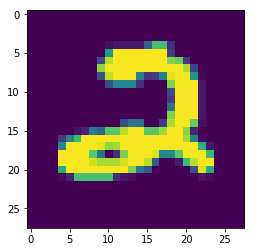

tensor(1)

In [7]:
eg=test_x[0,0,:,:]
plt.imshow(eg)
plt.show()
train_y[0]

In [8]:
class MnistDataset(Dataset):
    
    def __init__(self, x, y=None):
        self.data = x
        self.labels = y
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        if self.labels is not None:
            return self.data[idx], self.labels[idx]
        else:
            return self.data[idx]


In [9]:
train_dataset = MnistDataset(train_x, train_y)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataloader))

val_dataset = MnistDataset(val_x, val_y)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(len(val_dataloader))

test_dataset = MnistDataset(test_x)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(test_dataloader))

2000
0
1334


In [10]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
total_step = len(train_dataloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/5], Step [100/2000], Loss: 0.1643
Epoch [1/5], Step [200/2000], Loss: 0.2352
Epoch [1/5], Step [300/2000], Loss: 0.1210
Epoch [1/5], Step [400/2000], Loss: 0.0200
Epoch [1/5], Step [500/2000], Loss: 0.0536
Epoch [1/5], Step [600/2000], Loss: 0.0322
Epoch [1/5], Step [700/2000], Loss: 0.0478
Epoch [1/5], Step [800/2000], Loss: 0.0075
Epoch [1/5], Step [900/2000], Loss: 0.1355
Epoch [1/5], Step [1000/2000], Loss: 0.0793
Epoch [1/5], Step [1100/2000], Loss: 0.0044
Epoch [1/5], Step [1200/2000], Loss: 0.0050
Epoch [1/5], Step [1300/2000], Loss: 0.1827
Epoch [1/5], Step [1400/2000], Loss: 0.3404
Epoch [1/5], Step [1500/2000], Loss: 0.1355
Epoch [1/5], Step [1600/2000], Loss: 0.0354
Epoch [1/5], Step [1700/2000], Loss: 0.0189
Epoch [1/5], Step [1800/2000], Loss: 0.0155
Epoch [1/5], Step [1900/2000], Loss: 0.6069
Epoch [1/5], Step [2000/2000], Loss: 0.0399
Epoch [2/5], Step [100/2000], Loss: 0.0103
Epoch [2/5], Step [200/2000], Loss: 0.0031
Epoch [2/5], Step [300/2000], Loss: 0.1926


In [12]:
# model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
# ans = torch.cuda.LongTensor() #build a tensor to concatenate answers
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images,labels in val_dataloader:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         print(total)
#         correct += (predicted == labels).sum().item()
#         ans = torch.cat((ans,predicted),0)

#     print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# ans = ans.cpu().numpy() 

# aa = pd.DataFrame(ans)
# aa.columns = ['Label']
# Id = range(1,aa.size+1)
# aa.insert(0, 'ImageId', Id)               #bulid the summit csv

# aa.to_csv('submit_pytorch.csv',index = False)    
# # Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')

In [13]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
ans = torch.cuda.LongTensor() #build a tensor to concatenate answers
with torch.no_grad():
    correct = 0
    total = 0
    for images in test_dataloader:
        images = images.to(device)
        #labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        #total += labels.size(0)
        #print(total)
        #correct += (predicted == labels).sum().item()
        ans = torch.cat((ans,predicted),0)

    #print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

ans = ans.cpu().numpy() 

aa = pd.DataFrame(ans)
aa.columns = ['Label']
Id = range(1,aa.size+1)
aa.insert(0, 'ImageId', Id)               #bulid the summit csv

aa.to_csv('foo_latest.csv',index = False)    
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')